In [1]:
import logging
# Set the logging level to ERROR
logging.getLogger("dask").setLevel(logging.ERROR)
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import shutil
from functools import wraps
import pandas as pd
import numpy as np
from dask import delayed
import dask.dataframe as dd
import dask.array as da
from dask.distributed import Client
from multiprocessing import Manager
import matplotlib.pyplot as plt
from cluster_config import create_local_cluster
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Setting random seed
np.random.seed(42)

### Clean up previous run ###
# Specify the path to the dask-worker-space folder
dask_worker_space_path = "./dask-worker-space"
# Remove the folder if it exists
shutil.rmtree(dask_worker_space_path, ignore_errors=True)

# Create a local cluster with multiple processes
cluster = create_local_cluster()

# Connect a Dask client to the cluster
client = Client(cluster)

df = dd.read_csv(
    './processing/stage_2_text_vectorized/tfidf_scores.csv', 
    blocksize='8MB',
    )

# Repartition the DataFrame into smaller partitions (e.g., 16 partitions for 16 cores)
df = df.repartition(npartitions=16)

# Split Date and Words
dt = dd.to_datetime(df.iloc[:,0])
word_cols = df.iloc[:,1:]

In [2]:
dt.head()

0   2007-05-01
1   2007-06-01
2   2007-07-01
3   2007-08-01
4   2007-09-01
dtype: datetime64[ns]

In [3]:
word_cols.head()

,2d,3d,accretion,action,active,adaptive,adversarial,algebra,algebraic,algorithm,...,violation,visual,vortex,walk,wave,weak,weighted,wireless,xray,zero
0,282.792860,747.929264,108.737587,403.648383,446.934257,617.929288,514.454154,726.371158,262.722684,1043.947468,...,111.105915,510.305351,139.379291,164.078355,686.031007,277.293008,263.186350,172.996861,310.178828,182.650267
1,4.485408,18.929619,0.949503,13.582658,5.115495,4.646520,10.594425,52.958721,12.638595,12.482902,...,1.721607,2.632901,2.805236,5.935663,12.811636,6.816510,3.621799,3.059312,3.910942,4.787435
2,8.850097,8.760307,0.356778,7.897533,7.275397,7.988480,7.924221,46.101915,19.533337,13.129846,...,2.641851,4.812808,2.745780,7.359801,10.259520,8.896086,5.069246,0.940441,3.282495,7.420554
3,4.917066,2.648000,0.518379,18.489403,2.791385,4.423146,3.929733,33.538298,6.370740,4.252380,...,6.528318,3.125313,5.304701,2.367043,7.680567,5.552537,0.860877,0.000000,0.746569,5.464673
4,2.605825,3.356231,0.728656,10.863832,0.892108,2.262258,1.245314,40.196346,10.056365,3.205404,...,9.073165,1.125362,2.061572,3.151494,5.711784,3.544969,2.000536,0.746334,1.107650,7.428623


In [4]:
from dask_ml.preprocessing import StandardScaler

# Convert the Dask DataFrame to a Dask Array
word_cols_array = word_cols.to_dask_array(lengths=True)
word_cols_array

standard_list = []

for row in word_cols_array:
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(row.reshape(-1, 1))
    values = scaled_data.compute().reshape(1, -1)[0]
    standard_list.append(values)

# print(standard_list)

words_standardized = pd.DataFrame(standard_list, columns=word_cols.columns)
words_standardized

,2d,3d,accretion,action,active,adaptive,adversarial,algebra,algebraic,algorithm,...,violation,visual,vortex,walk,wave,weak,weighted,wireless,xray,zero
0,-0.344804,0.773782,-0.763382,-0.054164,0.049932,0.461151,0.212308,0.721938,-0.393070,1.485663,...,-0.757686,0.202331,-0.689693,-0.630295,0.624926,-0.358030,-0.391955,-0.608848,-0.278945,-0.585632
1,-0.482216,0.985384,-0.841481,0.442107,-0.418196,-0.465846,0.138489,4.442901,0.346186,0.330367,...,-0.763031,-0.670440,-0.652930,-0.334863,0.363768,-0.245365,-0.569963,-0.627114,-0.540585,-0.451529
2,0.071643,0.061160,-0.919928,-0.039567,-0.112199,-0.028949,-0.036451,4.420684,1.318880,0.571291,...,-0.653152,-0.399699,-0.641019,-0.102345,0.236189,0.077012,-0.369761,-0.851787,-0.578359,-0.095252
3,-0.092390,-0.354387,-0.600282,1.474733,-0.337831,-0.149420,-0.206392,3.212346,0.075458,-0.169138,...,0.093652,-0.299274,-0.047632,-0.386827,0.226696,-0.019016,-0.560736,-0.660137,-0.573934,-0.029161
4,-0.412504,-0.314482,-0.657708,0.666197,-0.636358,-0.457382,-0.590220,4.497753,0.560722,-0.334184,...,0.432292,-0.605889,-0.483597,-0.341226,-0.006788,-0.289828,-0.491569,-0.655399,-0.608202,0.217474
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192,-0.411473,0.781835,-0.773867,-0.161887,-0.107094,0.368814,0.751729,0.568677,-0.495003,1.709205,...,-0.808719,0.206868,-0.622857,-0.629540,0.854067,-0.314120,-0.363542,-0.502702,-0.219553,-0.617174
193,-0.503415,0.403882,-0.853478,-0.124939,-0.202603,0.312663,0.548504,0.716548,-0.503456,1.728849,...,-0.700165,0.046451,-0.636296,-0.635641,0.798451,-0.295241,-0.422667,-0.282397,-0.279533,-0.502871
194,-0.127580,0.652768,-0.771728,-0.110005,-0.049794,0.378413,0.466890,0.533367,-0.497038,1.591414,...,-0.709557,0.000052,-0.707289,-0.656139,0.862117,-0.446292,-0.509787,-0.472393,-0.058144,-0.610613
195,-0.378741,0.516338,-0.764284,-0.134869,-0.031542,0.365657,0.540528,0.610642,-0.452465,1.757007,...,-0.766234,0.021673,-0.631660,-0.573824,0.911252,-0.195858,-0.508342,-0.476279,-0.253336,-0.680011


In [5]:
from dask_ml.decomposition import PCA
import dask.array as da

# Assuming you have a Pandas DataFrame 'df'
X = da.from_array(standard_list)

# Adjust the chunk size to evenly divide the data
chunk_size = (197, 5)  # 197 rows, 5 columns
X = X.rechunk(chunk_size)

# Initialize PCA with the desired number of components
pca = PCA(n_components=60)

# Fit and transform the data
X_pca = pca.fit_transform(X)

In [6]:
explained_variance = pca.explained_variance_
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = explained_variance_ratio.cumsum()
principal_components = pca.components_
singular_values = pca.singular_values_
noise_variance = pca.noise_variance_

print(f'Noise Variance: {noise_variance}\n')

for i in range(0,60):
    print(f'Top {i+1} Principal Components explain {cumulative_explained_variance[i]}%')

top_pca = principal_components[:20]

Noise Variance: 0.0426914538153021

Top 1 Principal Components explain 0.41870055269915907%
Top 2 Principal Components explain 0.5722256204596473%
Top 3 Principal Components explain 0.6544084397838326%
Top 4 Principal Components explain 0.7199551756991198%
Top 5 Principal Components explain 0.7785664795219959%
Top 6 Principal Components explain 0.8042528239777043%
Top 7 Principal Components explain 0.8240073033008273%
Top 8 Principal Components explain 0.8360742605137654%
Top 9 Principal Components explain 0.8461269354082338%
Top 10 Principal Components explain 0.8550486321920022%
Top 11 Principal Components explain 0.8621796385379338%
Top 12 Principal Components explain 0.8680506079023819%
Top 13 Principal Components explain 0.8734608891215468%
Top 14 Principal Components explain 0.8779328346605197%
Top 15 Principal Components explain 0.8820497470052484%
Top 16 Principal Components explain 0.8853371341332734%
Top 17 Principal Components explain 0.8885743436990484%
Top 18 Principal Com

In [7]:
top_pca

array([[ 0.00494628, -0.04728052,  0.02888084, ..., -0.0156844 ,
         0.08086987,  0.00367395],
       [-0.00126059,  0.0259333 ,  0.05837327, ..., -0.01179601,
         0.17664348, -0.0175237 ],
       [-0.00427053, -0.02438273, -0.00831453, ...,  0.01685587,
         0.0021146 , -0.00508835],
       ...,
       [-0.036181  , -0.04090474, -0.00144903, ...,  0.04575446,
         0.01535055, -0.05166276],
       [ 0.0276573 ,  0.0210945 ,  0.01801846, ..., -0.00793667,
        -0.00418088,  0.00723686],
       [-0.02282696, -0.0156945 , -0.01969896, ..., -0.01822948,
         0.13820534, -0.01785591]])

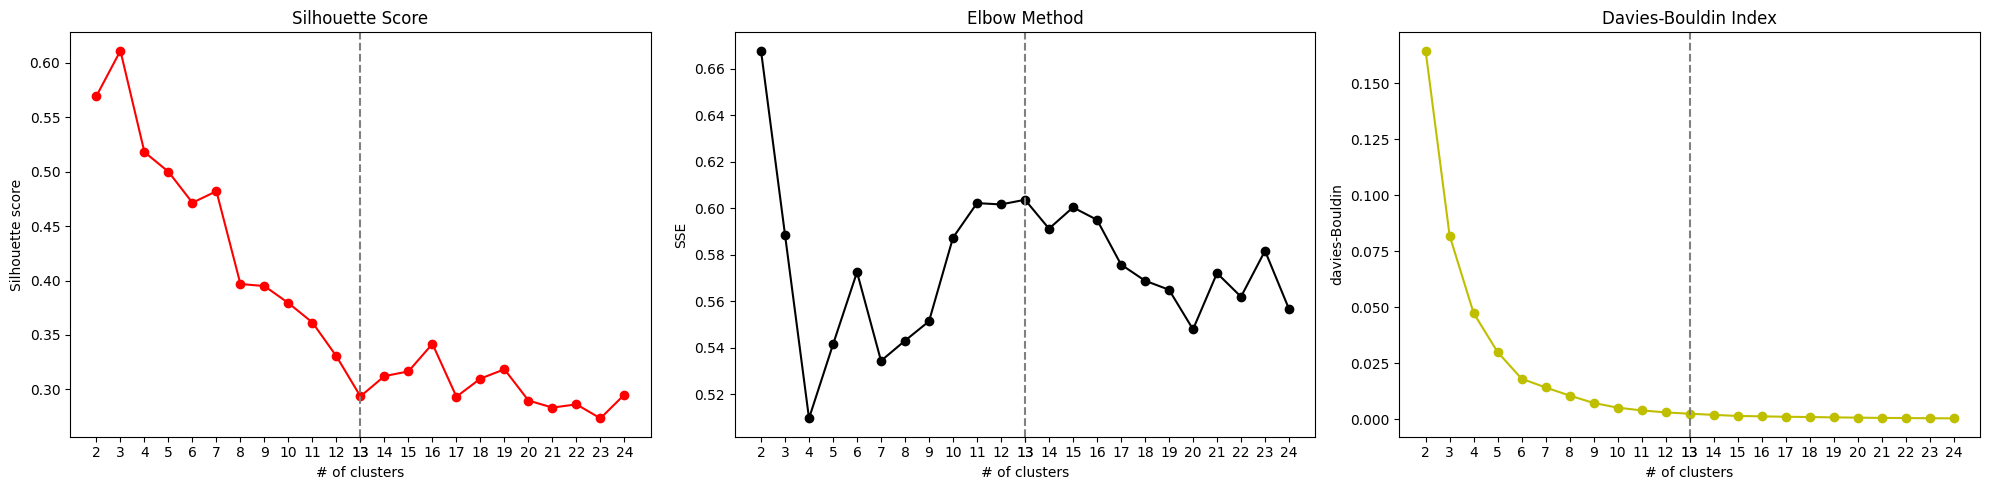

In [8]:

def find_optimal_cluster_count(pca_data, limit, repeat=5):
    pca_data_sample = pca_data[np.random.choice(pca_data.shape[0], int(0.01 * pca_data.shape[0]), replace=False)]
    average_of_silhouette, average_of_sse, average_of_davies = {}, {}, {}
    
    for _ in range(repeat):
        silhoutete = {}
        squared_sum_error = {}
        davies_bouldin = {}

        for k in range(2, limit):
            kmeans = KMeans(n_clusters=k, max_iter=500, random_state=100).fit(pca_data_sample)
            clusters = kmeans.labels_
            
            silhoutete[k] = silhouette_score(pca_data_sample, clusters) + silhoutete.get(k, 0)
            squared_sum_error[k] =  kmeans.inertia_ + squared_sum_error.get(k, 0)
            davies_bouldin[k] = davies_bouldin_score(pca_data_sample, clusters) + davies_bouldin.get(k, 0)
            
        for k in range(2, limit):
            average_of_silhouette[k] = (silhoutete[k] / repeat) + average_of_silhouette.get(k, 0)
            average_of_sse[k] =  (squared_sum_error[k] / repeat) + average_of_sse.get(k, 0)
            average_of_davies[k] = (davies_bouldin[k] / repeat) + average_of_davies.get(k, 0)

    return average_of_silhouette, average_of_sse, average_of_davies

# Call the function to check clustering
average_of_sse, average_of_davies, average_of_silhouette = find_optimal_cluster_count(top_pca.reshape(-1,1), 25)

plt.figure(figsize=(20, 5))

# Plot Silhouette Score
plt.subplot(1, 3, 1)
plt.plot(list(average_of_silhouette.keys()), list(average_of_silhouette.values()), marker='o', linestyle='-', color='r')
plt.xlabel("# of clusters")
plt.ylabel("Silhouette score")
plt.axvline(x=13, color='grey', linestyle='--', label='Selected Clusters')
plt.title("Silhouette Score")
plt.xticks(list(average_of_silhouette.keys()) + [13])

# Plot SSE
plt.subplot(1, 3, 2)
plt.plot(list(average_of_sse.keys()), list(average_of_sse.values()), marker='o', linestyle='-', color='black')
plt.xlabel("# of clusters")
plt.ylabel("SSE")
plt.axvline(x=13, color='grey', linestyle='--', label='Selected Clusters')
plt.title("Elbow Method")
plt.xticks(list(average_of_sse.keys()) + [13]) 

# Plot Davies-Bouldin Index
plt.subplot(1, 3, 3)
plt.plot(list(average_of_davies.keys()), list(average_of_davies.values()), marker='o', linestyle='-', color='y')
plt.xlabel("# of clusters")
plt.ylabel("davies-Bouldin")
plt.axvline(x=13, color='grey', linestyle='--', label='Selected Clusters')
plt.title("Davies-Bouldin Index")
plt.xticks(list(average_of_davies.keys()) + [13])

plt.tight_layout()
plt.show()


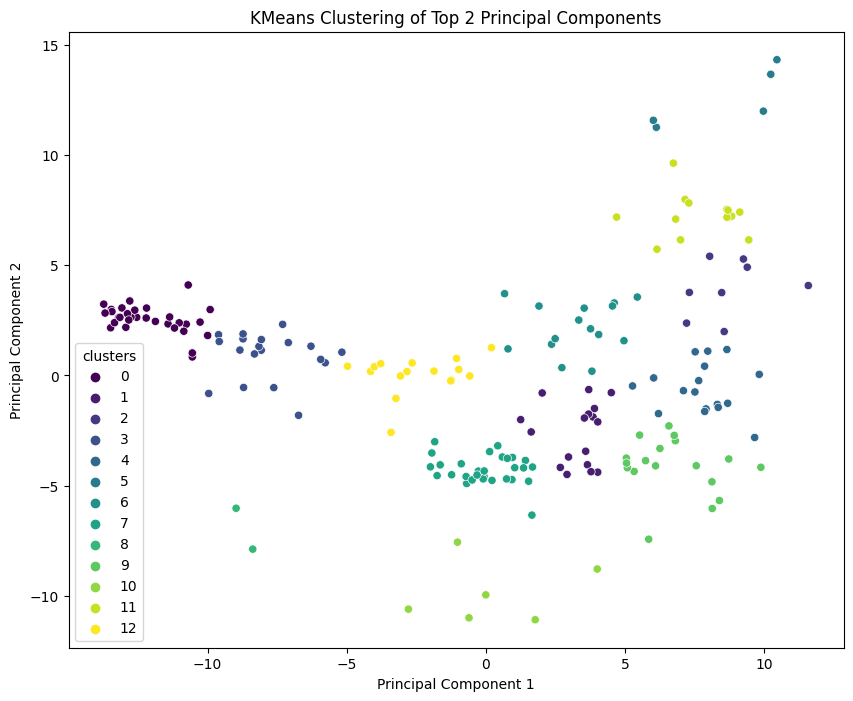

In [9]:
import pandas as pd
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df_pca is your DataFrame with PC1 and PC2 columns
df_pca = pd.DataFrame({'PC1': X_pca.compute()[:, 0], 'PC2': X_pca.compute()[:, 1]})

# Number of clusters
n_clusters = 13

# Perform KMeans clustering
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
df_pca['clusters'] = kmeans.fit_predict(df_pca[['PC1', 'PC2']])

# Plotting
plt.figure(figsize=(10, 8))
sns.scatterplot(x='PC1', y='PC2', hue='clusters', data=df_pca, palette='viridis', legend='full')
plt.title('KMeans Clustering of Top 2 Principal Components')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

In [10]:
# Assuming you have a DataFrame 'pca_data' with the top 20 principal components
kmeans = KMeans(n_clusters=13, random_state=42)  # Adjust the number of clusters
top_pca_clusters = kmeans.fit_predict(words_standardized)

# Get cluster assignments
clusters = kmeans.labels_
centers = kmeans.cluster_centers_
print('Clusters: ',clusters)
print('')
print('Centers: ',centers)
print('')
print('Centers Shape: ',centers.shape)
print('')

words_standardized['clusters'] = top_pca_clusters
words_standardized['YearMonth'] = dt

Clusters:  [ 2  0  0  9  0  0  6 11 11  2  0  6  0  4 12  4  7 12  2  3  9 10 10  4
  5  6  6  6  8  2  2  6  6  6  9  3 10 10  9  9  5  5  8  5  5  5  9 10
 10 10  5  9  1  1  1  4  4  4  4  4 10  9  1 12 12  4 12 12  7  7  7  7
  1  9  5  5  9  5  5  5  9  5  1  5  5  5  5  5  5  6  6  6  6  5  5  6
  9  3  6  5  6  6  6  6  6  6  6  6  6  6  6  8  8  6  6  6  6  3  3  3
  7  7  7  7  7  7  7  7  7  7  3  3  3  3  3  3  3  3  3  3  3  6  3  8
  3  3  8  3  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  2  2  2
  8  8  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2]

Centers:  [[-0.30954598 -0.02222736 -0.75319402 ... -0.72679236 -0.59497816
  -0.07540094]
 [-0.40752971 -0.44686363  0.16513511 ... -0.85351339  2.36550734
  -0.60140258]
 [-0.42755501  0.46979094 -0.77464163 ... -0.52117147 -0.11532972
  -0.62699579]
 ...
 [-0.3861592  -0.39029389 -0.64920998 ... -0.79974417 -0.06895512
  -0.43663113]
 [-0.26451893 -0.14899852 -0.62204637 ... -0.667

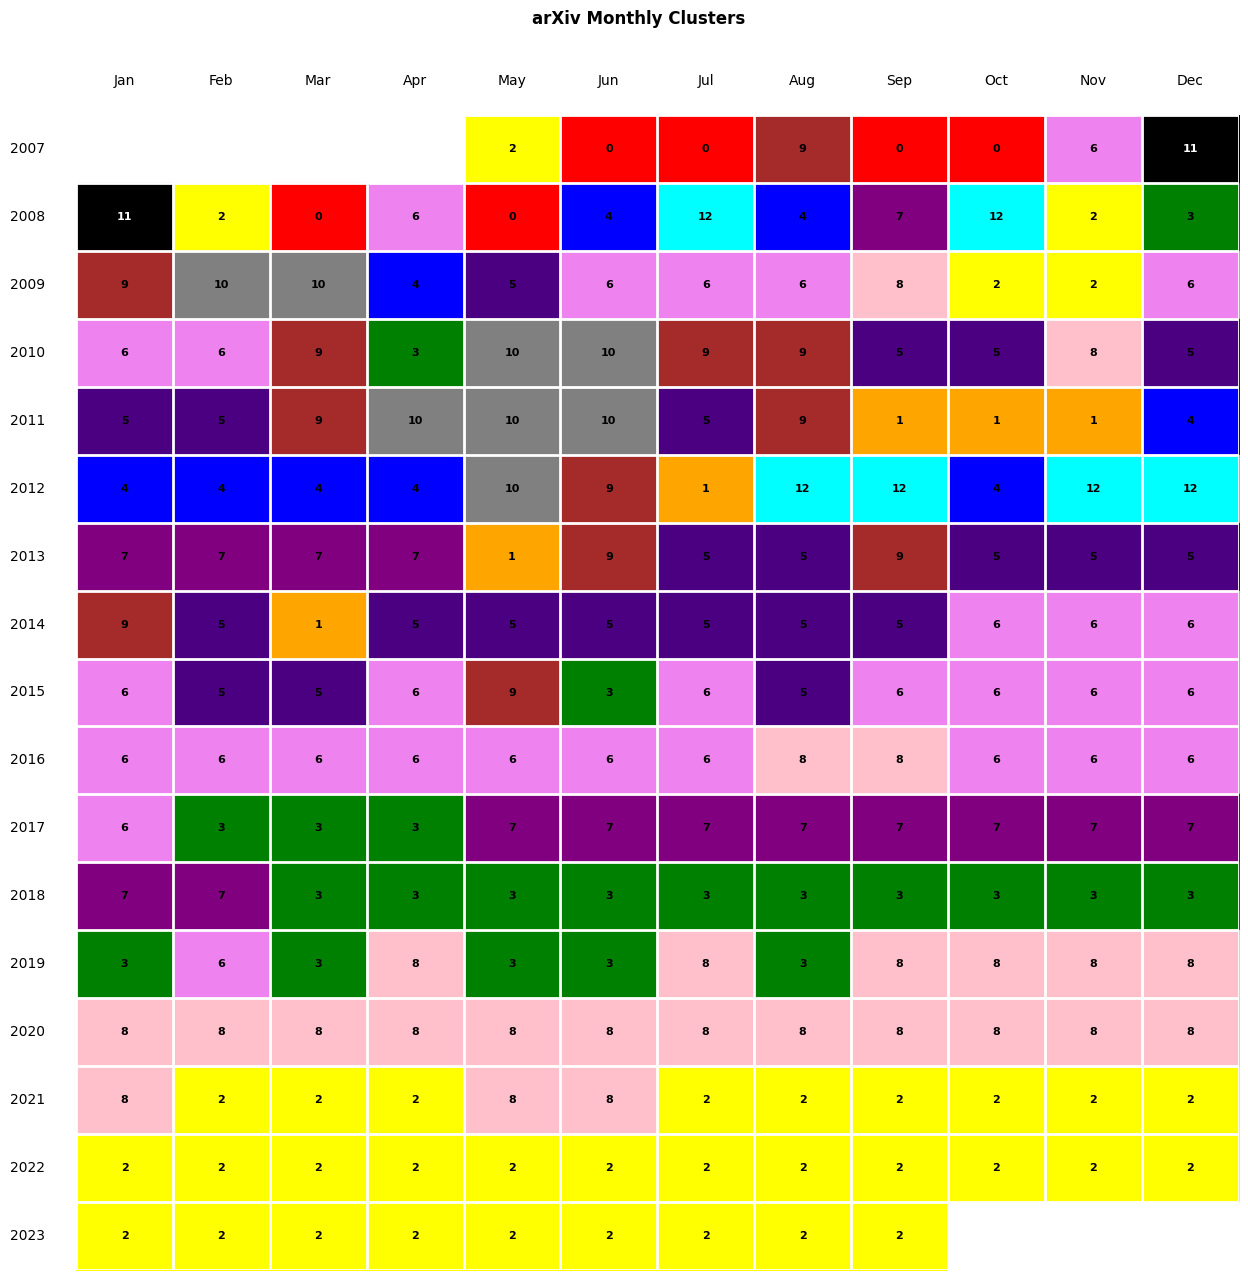

In [11]:
import matplotlib.pyplot as plt
import calendar
import numpy as np

# Assuming you have a DataFrame 'words_standardized' with 'YearMonth' and 'clusters' columns
# If not, adjust the column names accordingly

# Define colors for each cluster
cluster_colors = {
    0: 'red', 1: 'orange', 2: 'yellow', 3: 'green',
    4: 'blue', 5: 'indigo', 6: 'violet', 7: 'purple',
    8: 'pink', 9: 'brown', 10: 'gray', 11: 'black', 12: 'cyan'
}

# Set up the calendar
fig, ax = plt.subplots(figsize=(15, 15))  # Adjust the figure size as needed
ax.set_xlim(0, 12)
ax.set_ylim(0, (2023 - 2007 + 1))
ax.axis('off')

# Plot each month with its assigned color
for year in range(2007, 2024):
    for month in range(1, 13):
        # Get the corresponding cluster for the month
        mask = (words_standardized['YearMonth'].dt.year == year) & (words_standardized['YearMonth'].dt.month == month)
        if not words_standardized.loc[mask].empty:
            cluster = words_standardized.loc[mask, 'clusters'].values[0]
            ax.fill_betweenx(y=[2023 - year, 2023 - year + 1], x1=month - 1, x2=month, color=cluster_colors[cluster])
            # Determine text color based on the color of the month
            text_color = 'white' if cluster_colors[cluster] == 'black' else 'black'
            ax.text(month - 0.5, 2023 - year + 0.5, str(cluster), color=text_color, ha='center', va='center', fontsize=8, weight='bold')
        else:
            # If no data, fill with white
            ax.fill_betweenx(y=[2023 - year, 2023 - year + 1], x1=month - 1, x2=month, color='white')

# Add month names
for month, color in cluster_colors.items():
    ax.text(month - 0.5, 17.5, calendar.month_abbr[month], color='black', ha='center', va='center')

# Add year labels
for year in range(2023, 2006, -1):
    ax.text(-0.5, 2023 - year + 0.5, str(year), ha='center', va='center')

# Add month labels
ax.set_xticks(np.arange(0.5, 12.5, 1))
ax.set_xticklabels([calendar.month_abbr[i] for i in range(1, 13)])
ax.set_xlabel('Month')
fig.suptitle('arXiv Monthly Clusters', y=0.95, weight='bold')

# Draw grid lines
for i in range(0, 13):
    ax.plot([i - 0, i - 0], [0, (2023 - 2007 + 1)], color='white', linestyle='-', linewidth=2)
for i in range((2023 - 2007 + 1) + 1):
    ax.plot([0, 12], [i - 0, i - 0], color='white', linestyle='-', linewidth=2)

plt.show()

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer

###########################################
## Loading TFIDF vocabulary and rankings ##
###########################################

# Define data types for selected columns in a dictionary (preprocessed)
dtypes = {
    'title':'object',
    'categories': 'object',
    'abstract':'object',
    'update_date':'datetime',
}

df = dd.read_parquet(
    './processing/stage_1_text_preprocessed', 
    blocksize='8MB', 
    dtype=dtypes,
    )

# Reset the index to have a unique numerical index
df = df.reset_index(drop=True)

# Repartition the DataFrame into smaller partitions (e.g., 16 partitions for 16 cores)
df = df.repartition(npartitions=16)

# Convert the "update_date" column to period type
df['update_date_ym'] = df['update_date'].dt.to_period('M')
words_standardized['ym'] = words_standardized['YearMonth'].dt.to_period('M')

# Assuming 'clusters' is the column you want to assign from words_standardized.iloc[:,-2:]
# Merge the DataFrames based on the 'update_date_ym' and 'YearMonth' columns
df = dd.merge(df, words_standardized.iloc[:,-3:], left_on='update_date_ym', right_on='ym')

# Select relevant columns and drop the redundant 'YearMonth' column
df = df[['title', 'abstract', 'categories', 'update_date', 'update_date_ym', 'categories_encode', 'clusters']].compute()

# Compute the result (if needed)
df


,title,abstract,categories,update_date,update_date_ym,categories_encode,clusters
0,calculation prompt diphoton production cross s...,fully differential calculation perturbative qu...,hep-ph,2008-11-26,2008-11,0,2
1,polymer quantum mechanic continuum limit,rather nonstandard quantum representation cano...,gr-qc,2008-11-26,2008-11,6,2
2,crystal channeling lhc forward proton preserve...,show crystal trap broad x x e distribution par...,hep-ph,2008-11-26,2008-11,0,2
3,probing nonstandard neutrino interaction super...,analyze possibility probing nonstandard neutri...,hep-ph,2008-11-26,2008-11,0,2
4,scalar radius pion zero form factor,quadratic pion scalar radius la r2rapis play i...,hep-ph hep-lat nucl-th,2008-11-26,2008-11,25,2
...,...,...,...,...,...,...,...
145165,spinlattice relaxation metalorganic platinumii...,dynamic spinlattice relaxation slr metalorgani...,physics.chem-ph,2021-12-14,2021-12,151,2
145166,canonical decomposition poincare duality pair,author previously described algebraic analogue...,math.GR math.GT,2020-04-14,2020-04,648,8
145167,homogeneous fourier multiplier marcinkiewicz type,1995 paper contains sharp version classical ma...,math.FA math.CA,2020-04-29,2020-04,859,8
145168,relative cohomology banach algebra,let banach algebra necessarily unital let b cl...,math.OA,2020-04-28,2020-04,50,8


In [13]:
# Assuming your DataFrame is named df
grouped_by_cluster_df = df.groupby('clusters').agg({
    'title': ' '.join,
    'abstract': ' '.join,
    'categories': ' '.join
}).reset_index()

# Display the result
grouped_by_cluster_df

,clusters,title,abstract,categories
0,0,padic limit weakly holomorphic modular form ha...,serre obtained padic limit integral fourier co...,math.NT physics.ed-ph quant-ph cond-mat.str-el...
1,1,remark number steady state multiple futile cyc...,multisite phosphorylationdephosphorylation cyc...,q-bio.QM q-bio.MN physics.gen-ph q-bio.OT astr...
2,2,calculation prompt diphoton production cross s...,fully differential calculation perturbative qu...,hep-ph gr-qc hep-ph hep-ph hep-ph hep-lat nucl...
3,3,sparsitycertifying graph decomposition lifetim...,describe new algorithm kellpebble game color u...,math.CO cs.CG hep-ph q-fin.PR math.PR q-fin.GN...
4,4,computing genus 2 hilbertsiegel modular form q...,paper present algorithm computing hecke eigens...,math.NT math.AG math.RT math.QA q-bio.NC cond-...
5,5,dyadic lambdaalpha lambdaalpha hardylorentz sp...,paper show compute lambdaalpha norm alphage 0 ...,math.CA math.FA math.CA math.FA q-bio.PE math....
6,6,spectroscopic observation intermediate polar e...,result spectroscopic observation intermediate ...,astro-ph astro-ph astro-ph math.AG math.CO nli...
7,7,multilinear function series conditionally free...,case freeness monotonic independence notion co...,math.OA math.FA cond-mat.supr-con math.DG math...
8,8,iterated integral loop product fillingfactorde...,article discus relation string topology differ...,math.CA math.AT cond-mat.mes-hall cs.NE cs.AI ...
9,9,bosonic character atomic cooper pair across re...,study twoparticle wave function paired atom fe...,cond-mat.mes-hall cond-mat.str-el cond-mat.sta...


In [14]:
%%script echo skipping
### Pickle File can be loaded instead of running this again!
# Clean up old garbage
client.restart()

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer  # Import the WordNet lemmatizer
import string

# Download the NLTK datasets (if not already downloaded)
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')  # Download WordNet data for lemmatization

# Create a WordNet lemmatizer instance
lemmatizer = WordNetLemmatizer()

# Define a function for text preprocessing with lemmatization
def preprocess_text(text):
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Tokenize the text into words
    words = word_tokenize(text)
    
    # Define a set of English stopwords from NLTK
    stop_words = set(stopwords.words('english'))
    
    # Lemmatize the words and remove stopwords
    filtered_words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    
    # Join the filtered words back into a sentence
    return ' '.join(filtered_words)

# Apply the preprocessing function to the 'title' and 'abstract' columns using map_partitions
grouped_by_cluster_df['title'] = grouped_by_cluster_df['title'].map(preprocess_text)
grouped_by_cluster_df['abstract'] = grouped_by_cluster_df['abstract'].map(preprocess_text)

# Display the updated DataFrame
grouped_by_cluster_df.head()

# Use the to_parquet method to write the Dask DataFrame to Parquet files
grouped_by_cluster_df.to_pickle('./processing/stage_3_classification/clustered_processed.pkl')

skipping


In [15]:
# This dataframe is where we group all the words not per month but per cluster.
# After that a word cloud can be generated per individual cluster to describe the themes present in the evolving scientific landscape.
xyz = pd.read_pickle('./processing/stage_3_classification/clustered_processed.pkl')
xyz

,clusters,title,abstract
0,0,evolution earthmoon system based dark matter f...,evolution earthmoon system described dark matt...
1,1,measurement hadronic form factor d0 k e nue de...,shape hadronic form factor fq2 decay d0 k e nu...
2,2,calculation prompt diphoton production cross s...,fully differential calculation perturbative qu...
3,3,dyadic lambdaalpha lambdaalpha hardylorentz sp...,paper show compute lambdaalpha norm alphage 0 ...
4,4,padic limit weakly holomorphic modular form ha...,serre obtained padic limit integral fourier co...
5,5,convergence discrete dipole approximation ii e...,propose extrapolation technique allows accurac...
6,6,computing genus 2 hilbertsiegel modular form q...,paper present algorithm computing hecke eigens...
7,7,spectroscopic observation intermediate polar e...,result spectroscopic observation intermediate ...
8,8,world evolving information english translation...,paper discus benefit describing world informat...
9,9,iterated integral loop product fillingfactorde...,article discus relation string topology differ...


In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_features=500, stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(xyz['abstract'])

# Now tfidf_matrix contains the TF-IDF vectors for each cluster
# You may convert it to a DataFrame if needed
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# Add the 'clusters' column back to the DataFrame
tfidf_df['clusters'] = grouped_by_cluster_df['clusters']
tfidf_df.index = tfidf_df['clusters']

In [17]:
# Iterate through each row
sorted_columns = []
for _, row in tfidf_df.iterrows():
    # Get the TF-IDF values for the row
    tfidf_values = row.drop('clusters').values
    
    # Get the corresponding column names and sort them based on TF-IDF values
    sorted_cols_for_row = [col for _, col in sorted(zip(tfidf_values, row.index[:-1]), reverse=True)]
    
    # Append the sorted columns for this row to the final list
    sorted_columns.append(sorted_cols_for_row)

LIMIT_TOP = 30

# Display the result
print(f"Top {LIMIT_TOP} words for each cluster based on their tfidf frequency significance (ordered descending):")
for i, cols in enumerate(sorted_columns):
    print(f"{cols[:LIMIT_TOP]}")

# Create sets for each array
array_sets = [set(array[:LIMIT_TOP]) for array in sorted_columns]

# Find words that are not in all arrays
unique_words = set.intersection(*array_sets)


LIMIT_UNIQUE = 25
# Print or use the results as needed
print('')
print(f"Words present in all clusters for first {LIMIT_UNIQUE} top terms:")
print(unique_words)
print('')

# Find words that are unique to each array
for i, array in enumerate(sorted_columns):
    unique_to_array = set(array[:LIMIT_UNIQUE]) - unique_words
    print(f"Words unique to cluster {i}: {unique_to_array}")


Top 30 words for each cluster based on their tfidf frequency significance (ordered descending):
['model', 'result', 'field', 'function', 'paper', 'quantum', 'state', 'study', 'space', 'method', 'time', 'using', 'problem', 'theory', 'case', 'equation', 'energy', 'number', 'structure', 'group', 'property', 'new', 'present', 'condition', 'set', 'based', 'data', 'order', 'point', 'solution']
['model', 'result', 'method', 'data', 'using', 'field', 'study', 'state', 'time', 'function', 'paper', 'energy', 'problem', 'present', 'mass', 'new', 'network', 'based', 'theory', 'approach', 'quantum', 'star', 'different', 'structure', 'number', 'parameter', 'property', 'algorithm', 'case', 'space']
['model', 'result', 'method', 'data', 'using', 'field', 'study', 'state', 'problem', 'function', 'paper', 'quantum', 'time', 'approach', 'theory', 'new', 'energy', 'network', 'present', 'based', 'different', 'learning', 'space', 'algorithm', 'structure', 'number', 'parameter', 'case', 'work', 'solution']
[

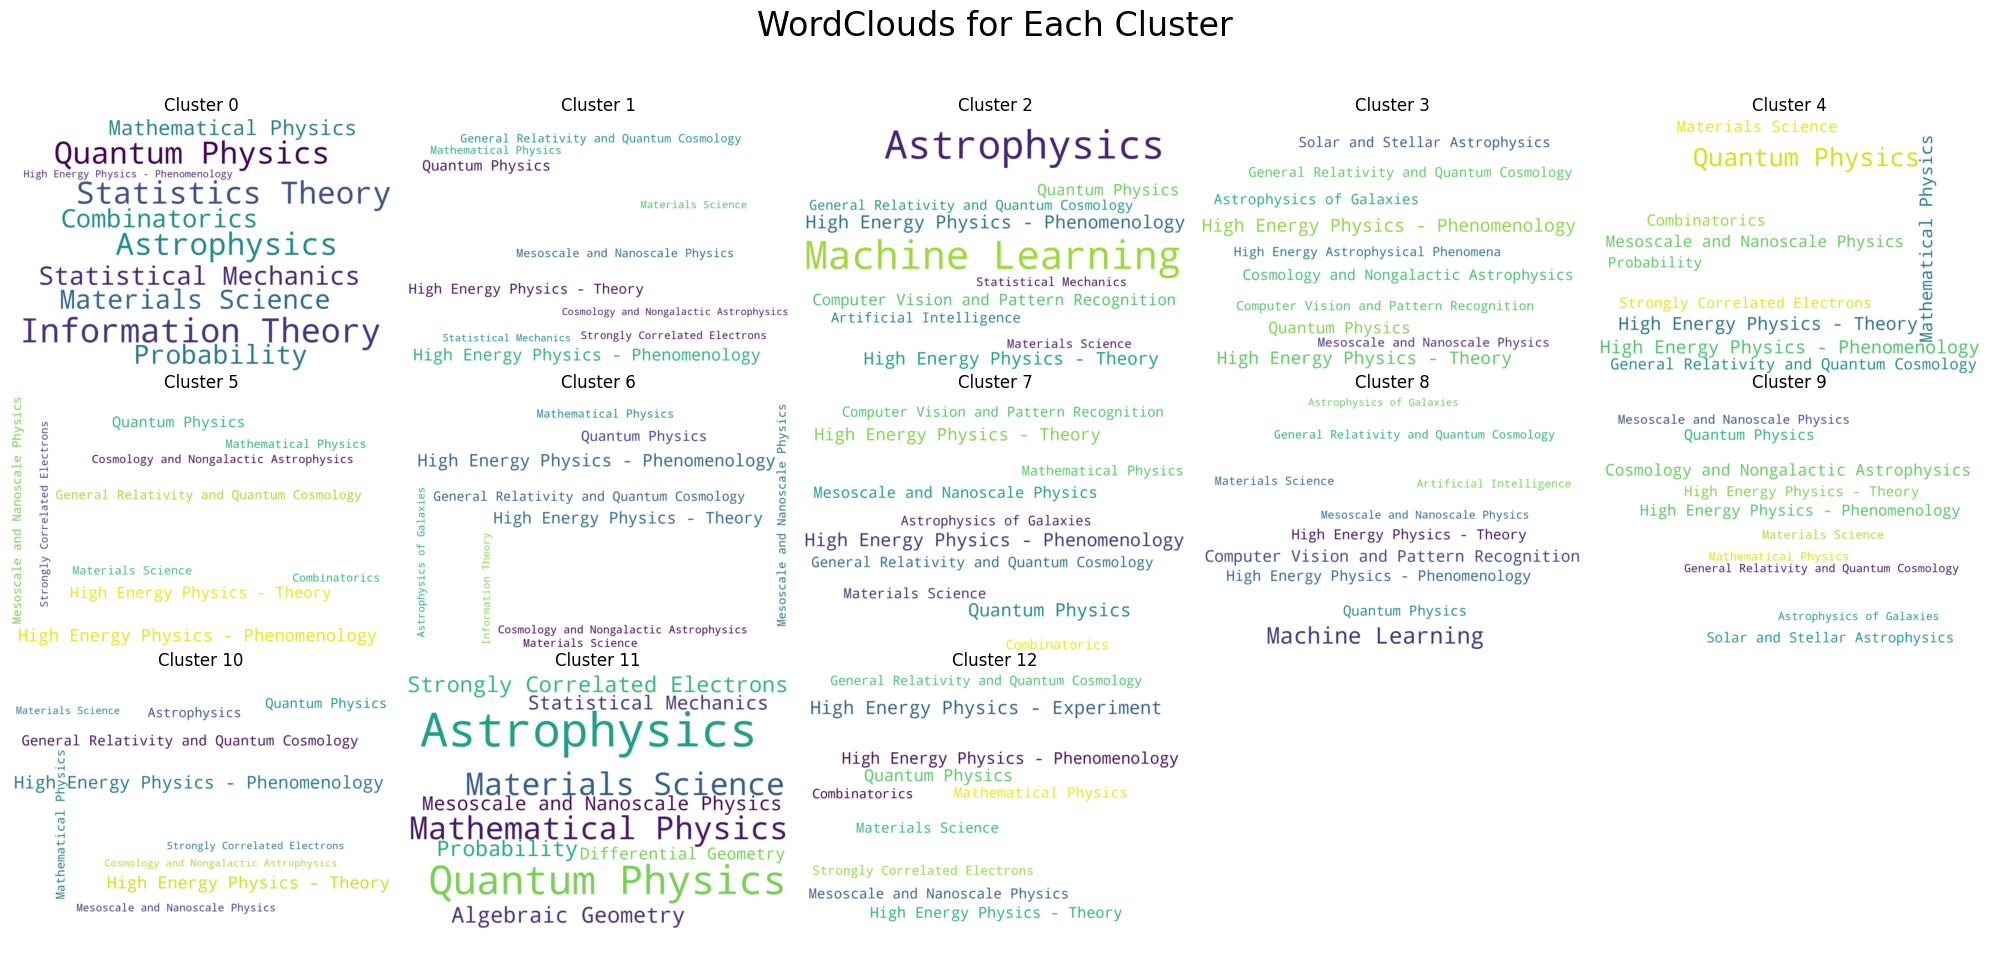

In [18]:
from collections import Counter
import json
from wordcloud import WordCloud
import matplotlib.pyplot as plt

with open('./arXiv/arXiv-categories-only-code-2023-10-09-deprecated-fixed.json', 'r') as file:
    category_label_mappings = json.load(file)

def look_up_category_name(code):
    for entry in category_label_mappings:
        if entry['code'] == code:
            return entry['name']
    return 'Category name not found'

# Assuming the number of clusters is the length of grouped_by_cluster_df
num_clusters = len(grouped_by_cluster_df['categories'])

# Determine the number of rows and columns for subplots
num_rows = min(3, num_clusters)
num_cols = min(5, -(-num_clusters // 3))  # Equivalent to math.ceil(num_clusters / 3)

# Create subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 10))
fig.suptitle('WordClouds for Each Cluster', fontsize=24)

for ci, ax in enumerate(axs.flatten()):
    if ci < num_clusters:  # Check if the cluster index is within the range
        words = []
        cluster_category = ci
        categories_labels_freq = Counter(grouped_by_cluster_df['categories'][cluster_category].split(' '))

        # Change keys to category names using look_up_category_name()
        categories_labels_freq_named = {look_up_category_name(code): freq for code, freq in categories_labels_freq.items()}

        # Generate WordCloud from frequencies
        wordcloud = WordCloud(width=1500, height=1000, background_color='white', max_words=10)
        wordcloud.generate_from_frequencies(categories_labels_freq_named)

        ax.imshow(wordcloud, interpolation='bilinear')
        ax.axis('off')
        ax.set_title(f'Cluster {cluster_category}')
    else:
        # If there are more subplots than clusters, remove the axis
        ax.axis('off')

# Adjust layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
